# Proyek Klasifikasi Gambar: [Animals]
- **Nama:** [Vittorio Fiorentino]
- **Email:** [a541ybm493@devacademy.id]
- **ID Dicoding:** [A541YBM493]

## Objective:
- Membangun sebuah model menggunakan CNN dan Transfer Learning yang dapat mengklasifikasikan jenis hewan melalui gambar.

## Sumber Dataset:
- https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset

## Import Semua Packages/Library

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [2]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vittoriofiorentino","key":"15a94ea2c5322f4530e8dcb91a8b1d39"}'}

In [3]:
import os
import shutil

# Hapus jika .kaggle bukan folder
#if os.path.exists("/root/.kaggle") and not os.path.isdir("/root/.kaggle"):
#    os.remove("/root/.kaggle")

# Buat folder .kaggle dan pindahkan file
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Atur permission agar bisa diakses
os.chmod("/root/.kaggle/kaggle.json", 600)


In [4]:

# Download dataset Animal Image Classification
!kaggle datasets download -d borhanitrash/animal-image-classification-dataset

# Unzip dataset
!unzip animal-image-classification-dataset.zip


Dataset URL: https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset
License(s): MIT
  0% 0.00/38.4M [00:00<?, ?B/s]
100% 38.4M/38.4M [00:00<00:00, 885MB/s]
Archive:  animal-image-classification-dataset.zip
  inflating: Animals/cats/0_0001.jpg  
  inflating: Animals/cats/0_0002.jpg  
  inflating: Animals/cats/0_0003.jpg  
  inflating: Animals/cats/0_0004.jpg  
  inflating: Animals/cats/0_0005.jpg  
  inflating: Animals/cats/0_0006.jpg  
  inflating: Animals/cats/0_0007.jpg  
  inflating: Animals/cats/0_0008.jpg  
  inflating: Animals/cats/0_0009.jpg  
  inflating: Animals/cats/0_0010.jpg  
  inflating: Animals/cats/0_0011.jpg  
  inflating: Animals/cats/0_0012.jpg  
  inflating: Animals/cats/0_0013.jpg  
  inflating: Animals/cats/0_0014.jpg  
  inflating: Animals/cats/0_0015.jpg  
  inflating: Animals/cats/0_0016.jpg  
  inflating: Animals/cats/0_0017.jpg  
  inflating: Animals/cats/0_0018.jpg  
  inflating: Animals/cats/0_0019.jpg  
  inflating: Animals/cats/0

### Data Preprocessing

#### Split Dataset

In [5]:
import os
import shutil
import random

original_path = "Animals"
train_path = os.path.join(original_path, "train")
test_path = os.path.join(original_path, "test")

test_ratio = 0.2  # 20% untuk test

# Buat folder train dan test
for split_path in [train_path, test_path]:
    os.makedirs(split_path, exist_ok=True)

# Ambil hanya folder kelas (bukan folder train/test itu sendiri)
class_names = [name for name in os.listdir(original_path)
               if os.path.isdir(os.path.join(original_path, name))
               and name not in ['train', 'test']]

for class_name in class_names:
    class_folder = os.path.join(original_path, class_name)

    images = os.listdir(class_folder)
    random.shuffle(images)

    split_idx = int(len(images) * (1 - test_ratio))
    train_images = images[:split_idx]
    test_images = images[split_idx:]

    # Buat folder kelas di train dan test
    os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

    # Salin gambar ke masing-masing folder
    for img in train_images:
        src = os.path.join(class_folder, img)
        dst = os.path.join(train_path, class_name, img)
        if os.path.isfile(src):
            shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(class_folder, img)
        dst = os.path.join(test_path, class_name, img)
        if os.path.isfile(src):
            shutil.copy(src, dst)

print("✅ Dataset berhasil dipisah ke folder train/test.")


✅ Dataset berhasil dipisah ke folder train/test.


### Gabung data ke dalam folder dataset

In [6]:
animals_path = "Animals"
dataset_path = os.path.join(animals_path, "dataset")

# Buat folder dataset kalau belum ada
os.makedirs(dataset_path, exist_ok=True)

# Folder yang mau di-skip
skip_folders = ['train', 'test', 'dataset']

# Pindahkan folder kelas ke dalam dataset/
for item in os.listdir(animals_path):
    item_path = os.path.join(animals_path, item)
    if os.path.isdir(item_path) and item not in skip_folders:
        target_path = os.path.join(dataset_path, item)
        shutil.move(item_path, target_path)
        print(f"✅ Pindah {item}/ ke dataset/")

print("📦 Semua folder kelas sudah dipindah ke Animals/dataset/. Folder Animals sekarang bersih!")


✅ Pindah cats/ ke dataset/
✅ Pindah dogs/ ke dataset/
✅ Pindah snakes/ ke dataset/
📦 Semua folder kelas sudah dipindah ke Animals/dataset/. Folder Animals sekarang bersih!


### Melihat jumlah gambar pada setiap kelas

In [7]:
path = "Animals/dataset"
for class_name in os.listdir(path):
    class_folder = os.path.join(path, class_name)
    if os.path.isdir(class_folder):
        num_images = len([f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{class_name}: {num_images} gambar")

cats: 1000 gambar
dogs: 1000 gambar
snakes: 1000 gambar


### Plot Gambar Untuk Semua Kelas

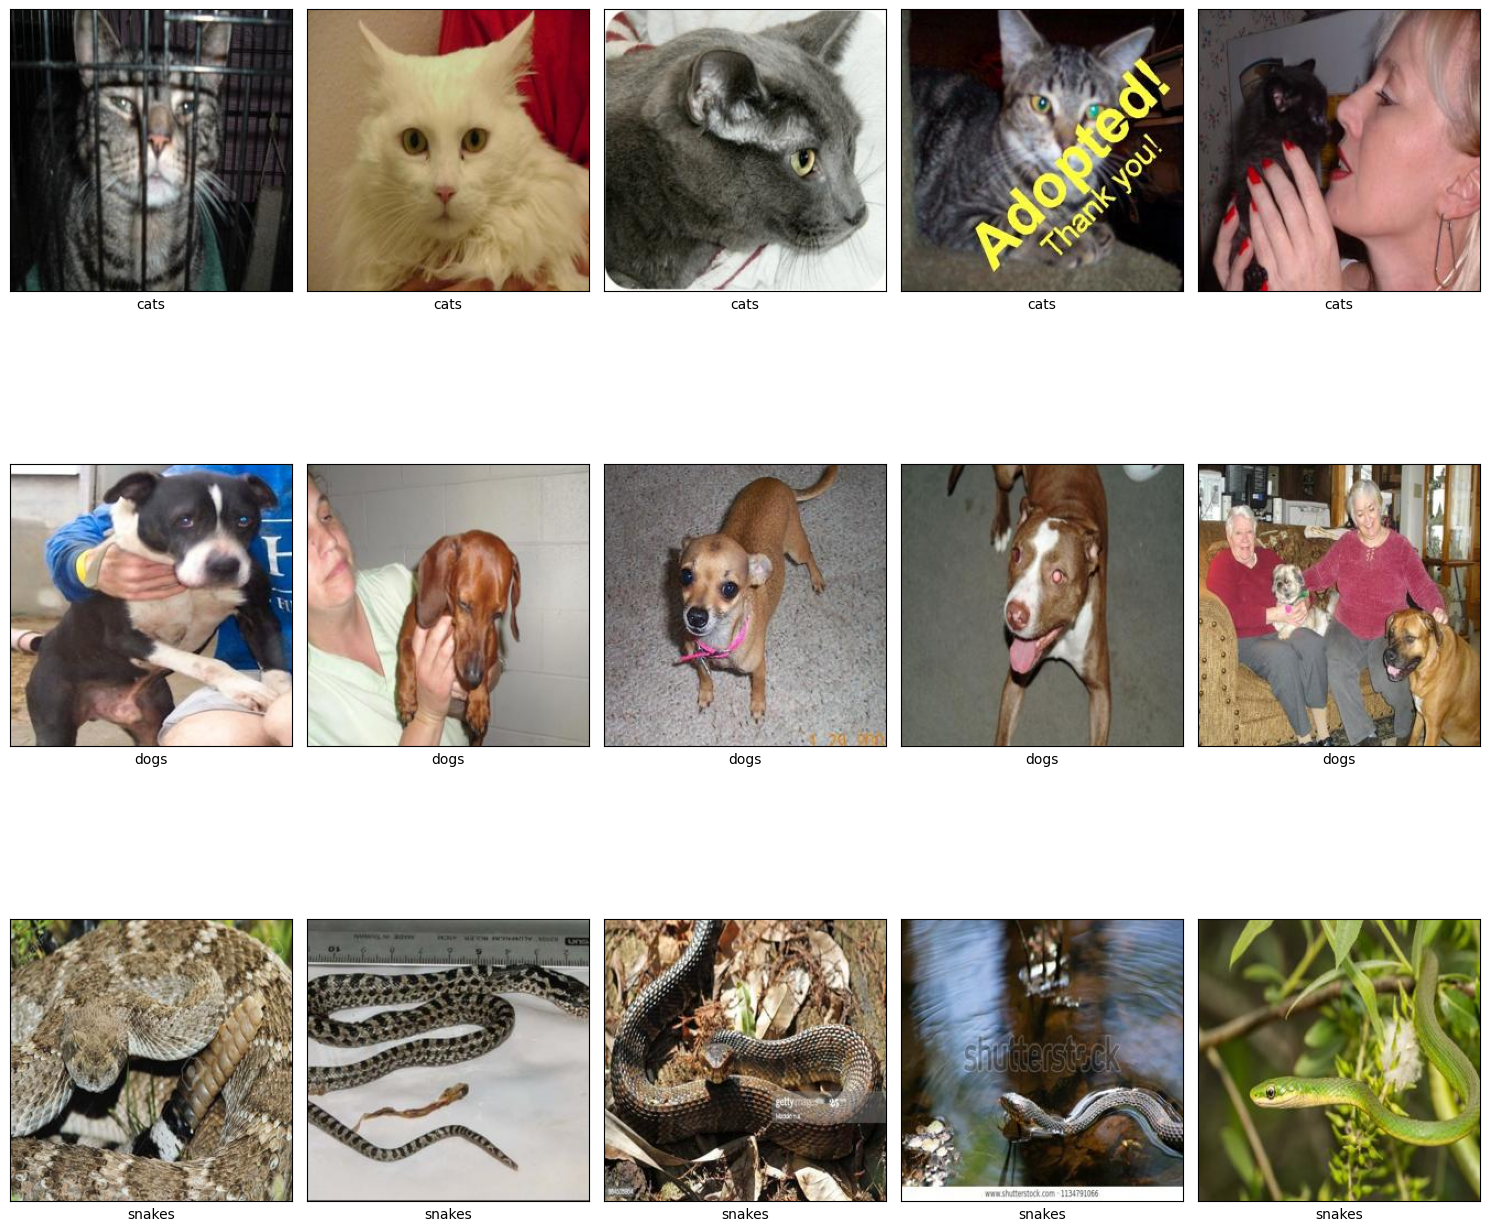

In [8]:

# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
animal_images = {}

# Tentukan path sumber
path = "Animals/"
path_sub = os.path.join(path, "dataset")

for i in os.listdir(path_sub):
    animal_images[i] = os.listdir(os.path.join(path_sub, i))

path_sub = "Animals/dataset/"


# Isi kamus dengan nama kelas dan daftar file gambar
for class_name in os.listdir(path_sub):
    class_folder = os.path.join(path_sub, class_name)
    if os.path.isdir(class_folder):
        animal_images[class_name] = os.listdir(class_folder)

# Menampilkan 5 gambar acak dari setiap kelas
fig, axs = plt.subplots(len(animal_images.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(animal_images[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("RGB")  # Untuk gambar hewan, lebih baik pakai RGB
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
#plt.show()


### Plot distribusi gambar di seluruh kelas

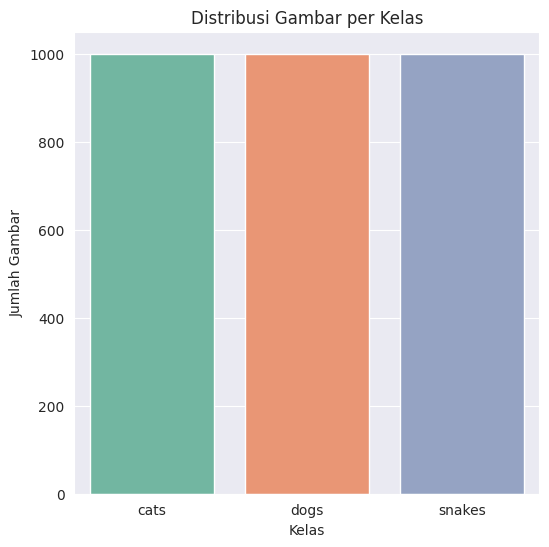

In [9]:
# Path dataset
animal_path = "Animals/dataset/"

# List untuk menyimpan informasi file
file_name = []
labels = []
full_path = []

# Looping ke semua file gambar di folder dataset
for path, subdirs, files in os.walk(animal_path):
    for name in files:
        if name.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path.append(os.path.join(path, name))
            labels.append(os.path.basename(path))  # nama kelas = nama folder
            file_name.append(name)

# Masukkan ke DataFrame
distribution_df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Plot distribusi jumlah gambar per kelas
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_df, x="labels", palette="Set2")

plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.show()

### Data Augmentasi

In [10]:
from skimage import exposure

# Fungsi augmentasi dengan input tensor float32 dan output numpy array
def anticlockwise_rotation(img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 3))  # rotasi 90,180,270 derajat ccw
    return img.numpy()

def clockwise_rotation(img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize(img, (224, 224))
    # rotasi searah jarum jam dengan 90,180,270 derajat (3-kali ccw = 1 kali cw)
    img = tf.image.rot90(img, k=4-random.randint(1, 3))
    return img.numpy()

def flip_up_down(img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img.numpy()

def add_brightness(img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))
    # pastikan clip nilai supaya gak out of bound
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img.numpy()

def blur_image(img):
    # Untuk blur pakai OpenCV (karena tf.image tidak punya blur)
    img = cv2.resize(img, (224, 224))
    img = cv2.GaussianBlur(img, (3,3), 0)
    # Normalisasi kembali ke 0-1 float
    img = img.astype(np.float32) / 255.0
    return img

def sheared(img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize(img, (224, 224))
    datagen = ImageDataGenerator(shear_range=0.2)
    img_aug = next(iter(datagen.flow(tf.expand_dims(img.numpy(), 0))))[0]
    return img_aug

def warp_shift(img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize(img, (224, 224))
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img_aug = next(iter(datagen.flow(tf.expand_dims(img.numpy(), 0))))[0]
    return img_aug

# Semua fungsi augmentasi
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

# Folder dataset original
dataset_path = "Animals/dataset"
# Folder hasil augmentasi
augmented_folder_suffix = "_augmented"

# Buat folder augmented per kelas
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue
    augmented_path = os.path.join(dataset_path, class_name + augmented_folder_suffix)
    os.makedirs(augmented_path, exist_ok=True)

    print(f"📦 Processing class: {class_name}")

    # Ambil semua gambar kelas tersebut
    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    images_to_generate = 200  # jumlah gambar augmentasi yang ingin dibuat per kelas
    i = 1
    while i <= images_to_generate:
        img_path = random.choice(images)
        try:
            original_image = io.imread(img_path)

            # Jika grayscale, convert ke RGB 3 channel
            if original_image.ndim == 2:
                original_image = np.stack([original_image]*3, axis=-1)

            # Normalisasi ke 0-1 float
            if original_image.dtype != np.float32 and original_image.dtype != np.float64:
                original_image = original_image / 255.0
            else:
                if original_image.max() > 1.0 or original_image.min() < 0.0:
                    original_image = exposure.rescale_intensity(original_image, in_range='image', out_range=(0, 1))

            transformed_image = None
            n = 0
            transformation_count = random.randint(1, len(transformations))  # jumlah transformasi acak

            while n < transformation_count:
                key = random.choice(list(transformations))
                transformed_image = transformations[key](original_image if transformed_image is None else transformed_image)
                n += 1

            # Convert kembali ke uint8 0-255 untuk simpan file
            transformed_image_uint8 = img_as_ubyte(transformed_image)
            save_path = os.path.join(augmented_path, f"augmented_{i:04d}.jpg")
            cv2.imwrite(save_path, cv2.cvtColor(transformed_image_uint8, cv2.COLOR_RGB2BGR))
            i += 1
        except Exception as e:
            print(f"⚠️ Gagal proses gambar {img_path}: {e}")

print("✅ Proses augmentasi selesai!")


📦 Processing class: cats
📦 Processing class: dogs
📦 Processing class: snakes
✅ Proses augmentasi selesai!


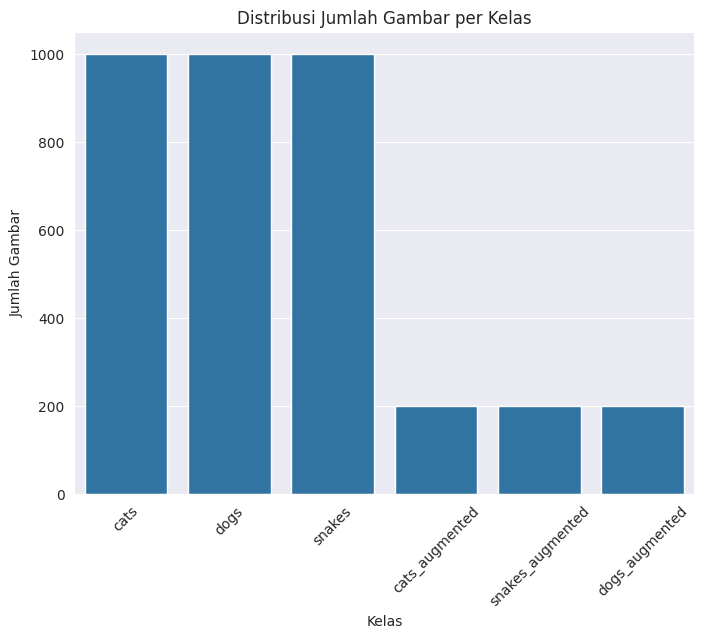

In [11]:

# Definisikan path dataset sesuai folder Animals-mu
animals_path = "Animals/dataset/"

file_names = []
labels = []
full_paths = []

# Loop untuk ambil nama file, path, dan label (nama folder kelas)
for path, subdirs, files in os.walk(animals_path):
    for name in files:
        if name.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_paths.append(os.path.join(path, name))
            labels.append(os.path.basename(path))  # ambil nama folder sebagai label
            file_names.append(name)

# Buat DataFrame
distribution_df = pd.DataFrame({
    "path": full_paths,
    "file_name": file_names,
    "labels": labels
})

# Plot distribusi gambar per kelas
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_df, x="labels", order=distribution_df['labels'].value_counts().index)
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.show()


### Data Splitting : Train dan Test

In [12]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Panggil variabel mypath yang menampung folder dataset gambar
mypath = 'Animals/dataset/'

file_name = []
labels = []
full_path = []

# Looping untuk membaca path gambar, labelnya (berdasarkan nama folder), dan nama file
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])  # Label diambil dari nama folder
        file_name.append(name)

# Masukkan ke dataframe agar rapi
df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Melihat jumlah data gambar pada masing-masing label
print("Distribusi data:")
print(df.groupby(['labels']).size())

# Variabel yang digunakan pada pemisahan data ini
X = df['path']
y = df['labels']

# Split dataset menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300
)

# Gabungkan hasil split ke dalam dataframe
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

# Print ukuran data hasil split
print('Train size:', len(df_tr))
print('Test size:', len(df_te))


Distribusi data:
labels
cats                1000
cats_augmented       200
dogs                1000
dogs_augmented       200
snakes              1000
snakes_augmented     200
dtype: int64
Train size: 2880
Test size: 720


In [13]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

# Menampilkan jumlah gambar berdasarkan set (train/test) dan label (dogs, cats, snakes)
print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Menampilkan 5 sample data secara acak
print(df_all.sample(5))



set    labels          
test   cats                221
       cats_augmented       39
       dogs                189
       dogs_augmented       43
       snakes              196
       snakes_augmented     32
train  cats                779
       cats_augmented      161
       dogs                811
       dogs_augmented      157
       snakes              804
       snakes_augmented    168
dtype: int64 


                                                   path          labels    set
2668                    Animals/dataset/cats/0_0006.jpg            cats  train
1957  Animals/dataset/dogs_augmented/augmented_0057.jpg  dogs_augmented  train
686                   Animals/dataset/snakes/2_0404.jpg          snakes  train
1178  Animals/dataset/cats_augmented/augmented_0175.jpg  cats_augmented  train
3117                    Animals/dataset/dogs/1_0094.jpg            dogs   test


In [14]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "Animals/dataset/"

# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


In [15]:

for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['labels'], row['file_name'])

    # Buat direktori tujuan folder jika belum ada
    target_dir = os.path.join(dataset_path, row['set'], row['labels'])
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Tentukan nama dan lokasi tujuan file
    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(target_dir, destination_file_name)

    # Salin file jika belum ada di tujuan
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)


0it [00:00, ?it/s]

In [16]:

def merge_augmented(folder_base_path):
    classes = ['cats', 'dogs', 'snakes']  # sesuaikan dengan kelas
    for cls in classes:
        original_folder = os.path.join(folder_base_path, cls)
        augmented_folder = os.path.join(folder_base_path, f"{cls}_augmented")

        if os.path.exists(augmented_folder):
            # Pastikan folder asli ada
            if not os.path.exists(original_folder):
                os.makedirs(original_folder)

            # Pindahkan semua file dari folder augmented ke folder asli
            for filename in os.listdir(augmented_folder):
                src_path = os.path.join(augmented_folder, filename)
                dst_path = os.path.join(original_folder, filename)

                # Jika nama file sudah ada, bisa rename atau overwrite sesuai kebutuhan
                if not os.path.exists(dst_path):
                    shutil.move(src_path, dst_path)
                else:
                    print(f"File {dst_path} sudah ada, dilewati.")

            # Hapus folder augmented setelah pindah
            os.rmdir(augmented_folder)
            print(f"Folder {augmented_folder} sudah dipindahkan dan dihapus.")
        else:
            print(f"Folder {augmented_folder} tidak ditemukan, lanjut ke kelas berikutnya.")

# Contoh untuk train dan test
merge_augmented('Dataset-Final/train')
merge_augmented('Dataset-Final/test')


Folder Dataset-Final/train/cats_augmented sudah dipindahkan dan dihapus.
Folder Dataset-Final/train/dogs_augmented sudah dipindahkan dan dihapus.
Folder Dataset-Final/train/snakes_augmented sudah dipindahkan dan dihapus.
Folder Dataset-Final/test/cats_augmented sudah dipindahkan dan dihapus.
Folder Dataset-Final/test/dogs_augmented sudah dipindahkan dan dihapus.
Folder Dataset-Final/test/snakes_augmented sudah dipindahkan dan dihapus.


### Image Data Generator

In [17]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

# Buat path untuk masing-masing kelas
train_dogs = os.path.join(TRAIN_DIR, 'dogs')
train_cats = os.path.join(TRAIN_DIR, 'cats')
train_snakes = os.path.join(TRAIN_DIR, 'snakes')

test_dogs = os.path.join(TEST_DIR, 'dogs')
test_cats = os.path.join(TEST_DIR, 'cats')
test_snakes = os.path.join(TEST_DIR, 'snakes')

# Tampilkan jumlah gambar di setiap kelas pada dataset training dan testing
print("Total number of dog images in training set: ", len(os.listdir(train_dogs)))
print("Total number of cat images in training set: ", len(os.listdir(train_cats)))
print("Total number of snake images in training set: ", len(os.listdir(train_snakes)))

print("Total number of dog images in test set: ", len(os.listdir(test_dogs)))
print("Total number of cat images in test set: ", len(os.listdir(test_cats)))
print("Total number of snake images in test set: ", len(os.listdir(test_snakes)))


Total number of dog images in training set:  968
Total number of cat images in training set:  940
Total number of snake images in training set:  972
Total number of dog images in test set:  232
Total number of cat images in test set:  260
Total number of snake images in test set:  228


In [18]:

# Buat ImageDataGenerator untuk normalisasi dan split validasi dari training set
datagen = ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)


# Generator untuk test set
test_datagen = ImageDataGenerator(rescale=1/255.0)

# Generator untuk training
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',  # multiclass (3 kelas)
    subset='training',
    shuffle=True
)

# Generator untuk validasi
validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',  # multiclass (3 kelas)
    subset='validation',
    shuffle=False
)

# Generator untuk test set
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=1,
    class_mode='categorical',  # multiclass (3 kelas)
    shuffle=False
)


Found 2305 images belonging to 3 classes.
Found 575 images belonging to 3 classes.
Found 720 images belonging to 3 classes.


## Modelling

### CNN Architecture Using 128 Neurons in Conv Layer

In [26]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_3 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_3.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_3.add(Conv2D(128, (4, 4),padding='same', activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_3.add(Conv2D(128, (7, 7), padding='same', activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# Flatten layer
model_3.add(Flatten())
# 1nd Dense Layer
model_3.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_3.add(Dropout(0.5))
# 2nd Dense Layer
model_3.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_3.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_3.add(Dense(3, activation='softmax'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_3.compile(optimizer=tf.keras.optimizers.RMSprop(),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

# Summary of the Model Architecture
print(model_3.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 150, 150, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 150, 150, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 75, 75, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 37, 37, 128)    │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,387,331 (24.37 MB)

 Trainable params: 6,386,563 (24.36 MB)

 Non-trainable params: 768 (3.00 KB)

None


In [27]:
count_dogs = len(os.listdir(train_dogs))
count_cats = len(os.listdir(train_cats))
count_snakes = len(os.listdir(train_snakes))

total = count_dogs + count_cats + count_snakes

weight_dog = total / (3 * count_dogs)
weight_cat = total / (3 * count_cats)
weight_snake = total / (3 * count_snakes)

class_weights = {
    0: weight_dog,
    1: weight_cat,
    2: weight_snake
}

history_3 = model_3.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights
)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 42s 393ms/step - accuracy: 0.3774 - loss: 14.3452 - val_accuracy: 0.3287 - val_loss: 4.1347
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 265ms/step - accuracy: 0.4204 - loss: 6.1713 - val_accuracy: 0.3270 - val_loss: 3.0837
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 259ms/step - accuracy: 0.3553 - loss: 1.8475 - val_accuracy: 0.3374 - val_loss: 5.5677
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 322ms/step - accuracy: 0.3784 - loss: 1.2654 - val_accuracy: 0.3426 - val_loss: 2.2123
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 262ms/step - accuracy: 0.3650 - loss: 1.2502 - val_accuracy: 0.3357 - val_loss: 4.4043
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.4086 - loss: 1.3496 - val_accuracy: 0.3600 - val_loss: 1.7686
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 259ms/step - accuracy: 0.4134 - loss: 1.1159 - val_accuracy: 0.3670 - val_loss: 1.0926
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 252ms/step - accuracy: 0.4463 - loss: 1.0660 - val_acc

Dikarenakan uji coba modelling Conv2D, cukup rendah dengan nilai accuracy sekitar 0.5301, maka kita akan menggunakan transfer learning untuk meningkatkan nilai accuracy.

###Transfer Learning

Merupakan teknik menggunakan model deep learning yang sudah dilatih sebelumnya (seperti MobileNetV2) pada dataset besar seperti ImageNet, lalu menyesuaikannya (fine-tuning) untuk klasifikasi seperti hewan yang spesifik.

In [34]:
from tensorflow.keras.layers import  Resizing
from tensorflow.keras.applications import MobileNetV2

tf.keras.backend.clear_session()

model = Sequential([
    Input(shape=(150, 150, 3)),

    # Pre-trained MobileNetV2 sebagai feature extractor
    MobileNetV2(include_top=False, weights='imagenet', input_shape=(150, 150, 3)),

    # Tambahan Conv2D dan MaxPooling setelah MobileNetV2
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

<ipython-input-34-91903b97c4ad>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNetV2(include_top=False, weights='imagenet', input_shape=(150, 150, 3)),


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,643,555 (10.08 MB)

 Trainable params: 2,609,443 (9.95 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [35]:
from sklearn.utils import class_weight
# Ambil label dari generator (berdasarkan urutan kelas dari subfolder)
train_labels = train_generator.classes

# Hitung class weight untuk semua kelas (otomatis mendeteksi jumlah kelas)
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Konversi ke dictionary untuk dipakai di model.fit()
class_weights = dict(enumerate(class_weights_array))

%time


earlystop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


history_1 = model.fit(
    train_generator,
    epochs=40,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[earlystop, checkpoint]
)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
Epoch 1/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.5994 - loss: 1.0946

73/73 ━━━━━━━━━━━━━━━━━━━━ 91s 601ms/step - accuracy: 0.6008 - loss: 1.0894 - val_accuracy: 0.8991 - val_loss: 0.2519
Epoch 2/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8491 - loss: 0.3500

73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 264ms/step - accuracy: 0.8492 - loss: 0.3499 - val_accuracy: 0.9426 - val_loss: 0.1632
Epoch 3/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8926 - loss: 0.2663

73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 253ms/step - accuracy: 0.8925 - loss: 0.2665 - val_accuracy: 0.9600 - val_loss: 0.1349
Epoch 4/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 255ms/step - accuracy: 0.8840 - loss: 0.2457 - val_accuracy: 0.9426 - val_loss: 0.1899
Epoch 5/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - accuracy: 0.8995 - loss: 0.2129 - val_accuracy: 0.9513 - val_loss: 0.1832
Epoch 6/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 255ms/step - accuracy: 0.9038 - loss: 0.2116 - val_accuracy: 0.9478 - val_loss: 0.1695
Epoch 7/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 244ms/step - accuracy: 0.8954 - loss: 0.2185 - val_accuracy: 0.9652 - val_loss: 0.1548
Epoch 8/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9190 - loss: 0.1774

73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 264ms/step - accuracy: 0.9190 - loss: 0.1774 - val_accuracy: 0.9617 - val_loss: 0.1115
Epoch 9/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 244ms/step - accuracy: 0.9009 - loss: 0.1925 - val_accuracy: 0.9565 - val_loss: 0.1450
Epoch 10/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 256ms/step - accuracy: 0.9138 - loss: 0.1708 - val_accuracy: 0.9600 - val_loss: 0.1406
Epoch 11/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - accuracy: 0.9257 - loss: 0.1523 - val_accuracy: 0.9670 - val_loss: 0.1600
Epoch 12/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 256ms/step - accuracy: 0.9219 - loss: 0.1716 - val_accuracy: 0.9496 - val_loss: 0.1962
Epoch 13/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 244ms/step - accuracy: 0.9229 - loss: 0.1839 - val_accuracy: 0.9513 - val_loss: 0.1893
Epoch 14/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 257ms/step - accuracy: 0.9250 - loss: 0.1564 - val_accuracy: 0.9583 - val_loss: 0.1712
Epoch 15/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 244ms/step - accuracy: 0.9179 - loss: 0.1920 - val_accuracy:

Setelah menggunakan model Transfer Learning, accuracy pada model meningkat menjadi 0.9270

## Evaluasi dan Visualisasi

### Plot Accuracy dan Loss pada CNN

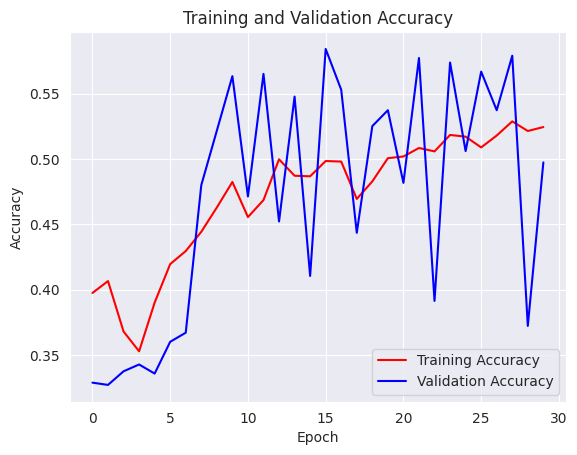

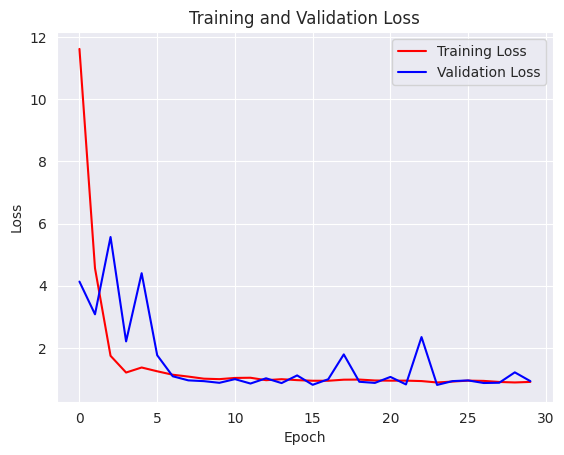

In [36]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epochs, loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Classification Report pada CNN

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


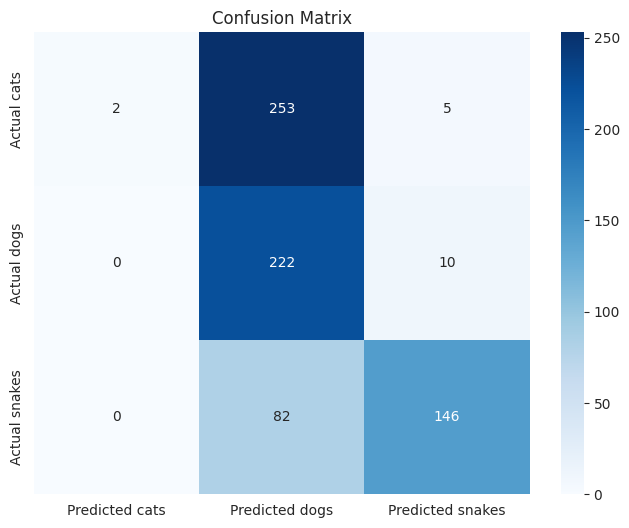


Classification Report:
              precision    recall  f1-score   support

        cats     1.0000    0.0077    0.0153       260
        dogs     0.3986    0.9569    0.5627       232
      snakes     0.9068    0.6404    0.7506       228

    accuracy                         0.5139       720
   macro avg     0.7685    0.5350    0.4429       720
weighted avg     0.7767    0.5139    0.4245       720



In [37]:
# Reset generator
test_generator.reset()

# Prediksi model
preds_3 = model_3.predict(test_generator, verbose=0)
y_pred = np.argmax(preds_3, axis=1)  # ambil index kelas dengan probabilitas tertinggi
y_true = test_generator.classes      # label asli dari test_generator

# Mapping label untuk membuat confusion matrix readable
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_true, y_pred),
                  index=[f"Actual {label}" for label in class_labels],
                  columns=[f"Predicted {label}" for label in class_labels])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

### Plot Accuracy dan Loss pada Transfer Learning

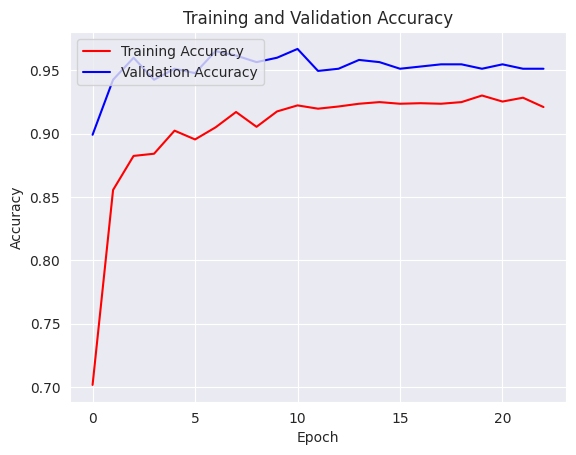

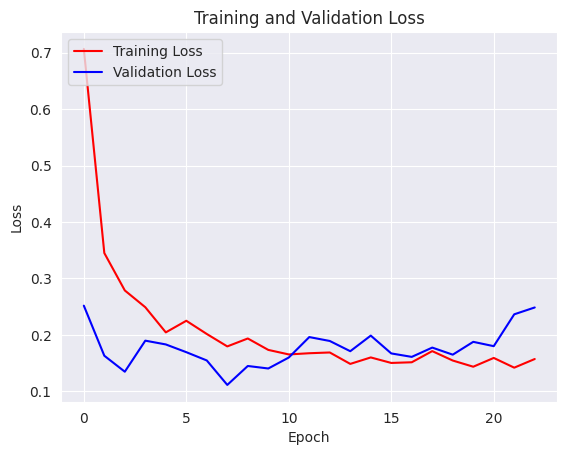

In [38]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

# Plot Akurasi
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


### Classification Report

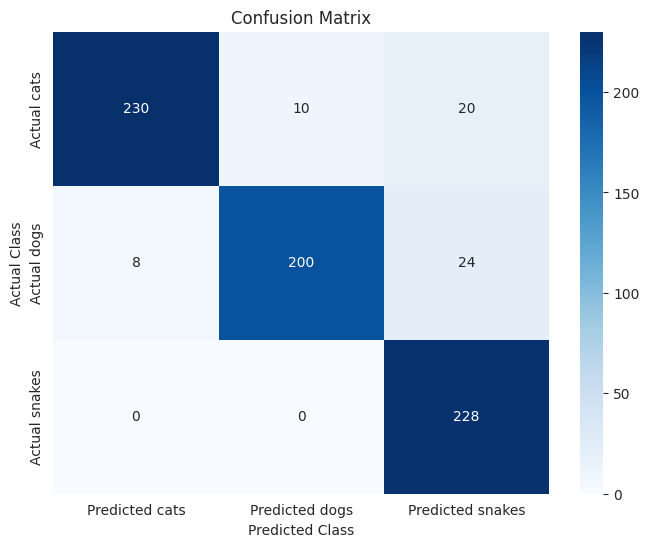


Classification Report:

              precision    recall  f1-score   support

        cats     0.9664    0.8846    0.9237       260
        dogs     0.9524    0.8621    0.9050       232
      snakes     0.8382    1.0000    0.9120       228

    accuracy                         0.9139       720
   macro avg     0.9190    0.9156    0.9136       720
weighted avg     0.9213    0.9139    0.9140       720



In [39]:
# Reset generator sebelum prediksi
test_generator.reset()

# Prediksi menggunakan model
preds_1 = model.predict(test_generator, verbose=0)

# Ambil index kelas dengan probabilitas tertinggi (argmax)
y_pred = np.argmax(preds_1, axis=1)
y_true = test_generator.classes

# Buat label nama kelas dari generator
labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=[f"Actual {label}" for label in labels],
                         columns=[f"Predicted {label}" for label in labels])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))


## Konversi Model

### Format saveModel

In [49]:
save_path = os.path.join("models/rps_model/1/")
tf.saved_model.save(model, save_path)


###Format TFJS

In [41]:
model.save("model.h5")

In [42]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [43]:
# mengubah model.h5 kedalam bentuk json
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-06-09 14:37:13.486277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749479833.507133   20766 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749479833.514340   20766 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


###Format TF-Lite

In [50]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)


In [51]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

In [52]:
labels = list(train_generator.class_indices.keys())

with open("labels.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")


Download Folder Model

In [47]:
!zip -r koko_model_all.zip models saved_model tfjs_model
from google.colab import files
files.download('koko_model_all.zip')


  adding: models/ (stored 0%)
  adding: models/rps_model/ (stored 0%)
  adding: models/rps_model/1/ (stored 0%)
  adding: models/rps_model/1/variables/ (stored 0%)
  adding: models/rps_model/1/variables/variables.index (deflated 77%)
  adding: models/rps_model/1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: models/rps_model/1/saved_model.pb (deflated 92%)
  adding: models/rps_model/1/assets/ (stored 0%)
  adding: models/rps_model/1/fingerprint.pb (stored 0%)
  adding: saved_model/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 77%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model/saved_model.pb (deflated 92%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard1of3.bin (deflated 7%)
  adding: t

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

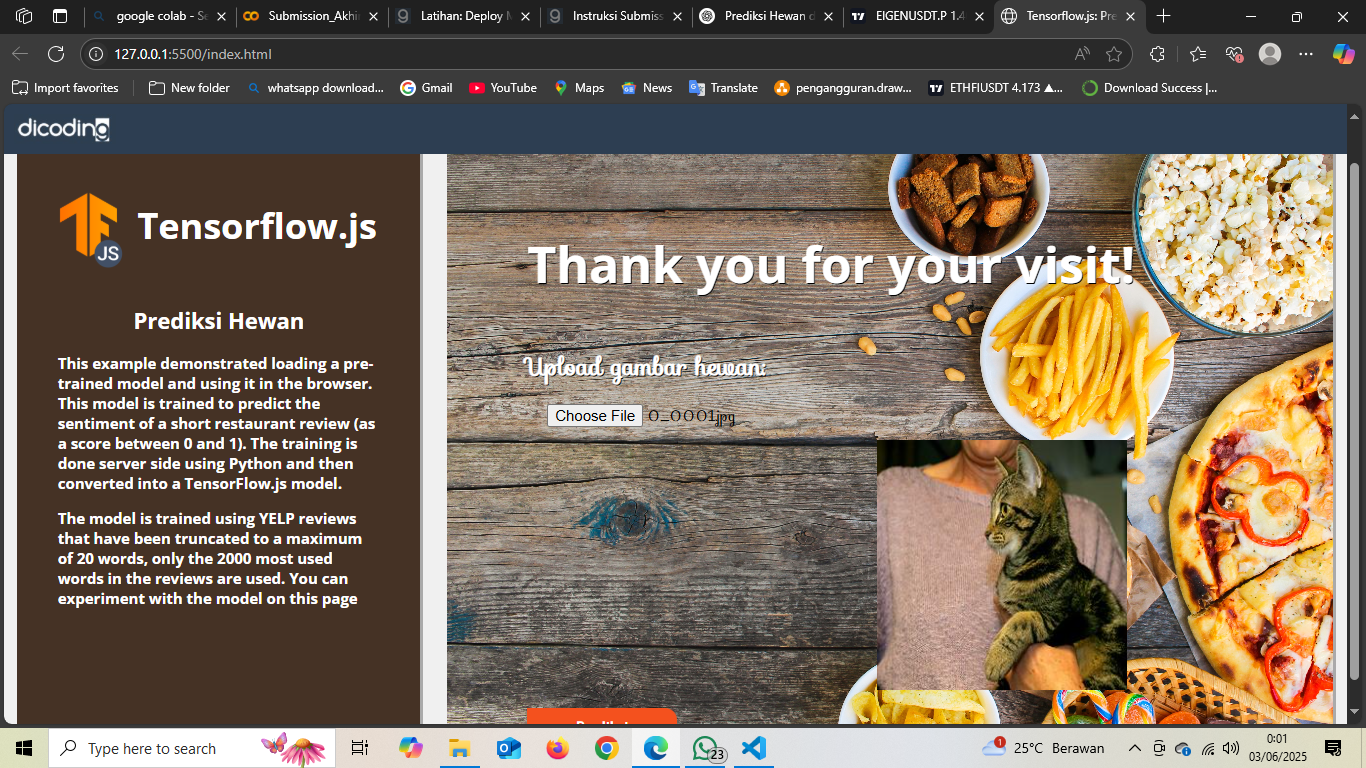

In [48]:
!pip freeze > requirements.txt
